In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
data = pd.read_csv('./rdata.csv').iloc[:,1:]

In [118]:
inflow, control, outflow, state =[], [], [], []
i = 0
for k in data.columns:
    if '进水' in k:
        inflow.append(i)
    elif 'DO' in k:
        control.append(i)
    elif '出水' in k:
        outflow.append(i)
    else:
        state.append(i)
    i += 1

title = {
    'inflow':inflow, # 进水
    'control':control, # set point of DO
    'state':state, # pool data
    'outflow':outflow,
}
state_index = title['inflow']+title['state']
control_index = title['control']
output_index = title['outflow']

index = {
    'state':state_index,
    'action':control_index,
}
np.save('index.npy',index)

In [119]:
p = np.load('./index.npy',allow_pickle=True).tolist()
print(p)

{'state': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19], 'action': [11, 12, 13]}


# 构建action space

In [86]:
# PLAN 1: -1到1之间，共3个位置9个DO值
actions = []
for i1 in np.arange(-1,1,2/10):
    for i2 in np.arange(-1,1,2/10):
        for i3 in np.arange(-1,1,2/10):
            actions.append([i1,i2,i3])
np.save('./action_table1.npy',actions)
print(len(actions))

1000


In [ ]:
action_table1 = np.load('./action_table1.npy',allow_pickle=True).tolist()

### Action数据转化

In [99]:
def a2action(a,action_table):
    # a: int, action: array
    return action_table[a]

def action2a(action,action_table):
    # a: int, action: array
    a = 0
    for i in range(len(action_table)):
        if action == action_table[i]:
            a = i
    return a

In [100]:
b = a2action(4,action_table1)
cc = action2a(action_table1[4],action_table1)

# 需要根据数据构建reward

In [70]:
# 出水达标、控制稳定
def reward(state,state_bar,action):
    # 用归一化后的state计算reward,size:M,
    #r1 = np.sum(np.abs(state[state_index]-state_bar[state_index])) # 过程稳定, small
    r2 = np.sum(state[output_index]+1) # 出水达标, small
    r3 = np.sum(action+1) # 减少曝气, small
    r = 0.6/r2 + 0.4/r3 
    return r

In [71]:
rewards = []
for i in range(data.values.shape[0]-1):
    state = data.values[i,:]
    state_bar = data.values[i+1,:]
    action = data.values[i,control_index]
    rewards.append(reward(state,state_bar,action))

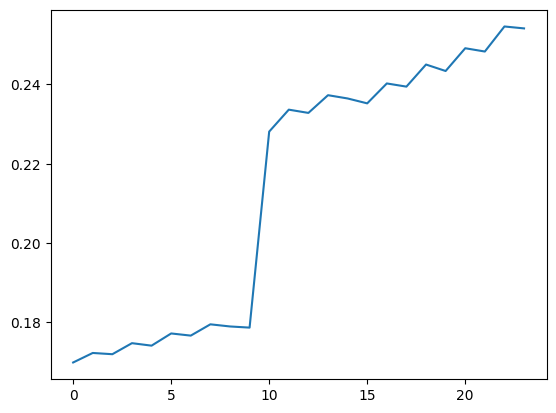

In [122]:
plt.plot(rewards[3:3+24])

# 构建pretrain data

In [123]:
# 分为50组
for i in range(data.values.shape[0]-24):
    results = {
        'state':data.values[i:i+24,state_index].tolist(),
        'action':data.values[i:i+24,control_index].tolist(),
        'reward':rewards[i:i+24]
    }
    np.save('./pretrain_data/pretraindata'+str(i)+'.npy',results)

In [124]:
pdata = np.load('./pretrain_data/pretraindata3.npy',allow_pickle=True).tolist()

In [126]:
len(pdata['state'][:])

24

# Ref data Check

In [107]:
refdata = np.load('./efd_results_rain0.npy',allow_pickle=True).tolist()

In [116]:
refdata['state']

[0,
 [0.0012960832085744526,
  0.011510789955685972,
  0.00026467385716913834,
  0.0033656169860917084,
  0.02116075920951917,
  0.015530807364680965,
  0.018658999846784336,
  0.001202453336318204,
  0.002868557164029864,
  0.016727836498208894,
  0.013559768956365126,
  0.001767226812287587,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0074815739252159915,
  0.02673086934180902,
  0.0016170750910143705,
  0.01477331798851297,
  0.04988200845902207,
  0.047655195619720724,
  0.03090456238881868,
  0.004214622863193219,
  0.007989155366119289,
  0.017466657461369575,
  0.014484423975071273,
  0.006124524697794825,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.019585153344225056,
  0.04025892364753034,
  0.005204668943229646,
  0.033372459353917784,
  0.07290683730945764,
  0.07456614004100623,
  0.03258113375902011,
  0.010456519786120683,
  0.011520185253501873,
  0.016499898279702063,
  0.013924689029038742,
  0.012065390639786107,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.03562781790625144,
  0.05206207796076879,
  